In [ ]:
# Normalize features to range [0, 1]
def normalize(df):
    from sklearn import preprocessing
    import pandas as pd

    try:
        x = df.drop('life_expectancy', axis=1).values
    except:
        x = df.values

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns=df.drop(columns='life_expectancy', errors='ignore').columns)

    if 'life_expectancy' in df.columns:
        df_scaled['life_expectancy'] = df['life_expectancy'].values

    return df_scaled

    
# def insert_into_table(conn, df, tablename):
#     curr = conn.cursor()
#     try:
#         command = f"""INSERT INTO {tablename} (""" 
#         final_part = ''
#         for idx in df.columns:
#             command = command + idx + ', '
#             final_part = final_part + '%s,'
#         command = command[:-2] + ') VALUES(' + final_part[:-1] + ')'
#         insert_into_videos = (command)
#         for i, row in df.iterrows():
#             row_to_insert = [row[column] for column in df.columns]
#             curr.execute(insert_into_videos, row_to_insert)
#     except Exception as e:
#         print(f'FALHA NO PREENCHIMENTO DA TABELA: {e}')
#         curr.execute("ROLLBACK")
#     conn.commit()

# def create_table(df, tablename, conn):
#     command = f"""CREATE TABLE {tablename} ( """
#     for idx in df.columns:
#         command += idx + ' '
#         if pd.api.types.is_integer_dtype(df[idx]):
#             command += 'INT,'
#         elif pd.api.types.is_float_dtype(df[idx]):
#             command += 'FLOAT,'
#         else:
#             command += 'VARCHAR,'
#     command = command[:-1] + ' )'
#     curr = conn.cursor()
#     try:
#         curr.execute(f'DROP TABLE IF EXISTS {tablename}')
#         curr.execute(command)
#     except Exception as e:
#         print(f'FALHA NA CRIAÇÃO DA TABELA: {e}')
#         curr.execute("ROLLBACK")
#     conn.commit()
#     insert_into_table(conn, df, tablename)


In [17]:
from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
 
def reg_lin(df, list_country,year):
    try:
        df.drop('country_name',axis=1,inplace=True)
    except: pass
    df1=df
    df.dropna(inplace=True)
    
    df_test=df[df['year']>year]
    df = df[df['year']<year+1]
    
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    ## Assign the predictor and response to variables. To fit the data, the pandas dataframe must be converted into a numpy
    ## array in a matricial shape, even if with a single column
    X_df = df.drop(columns = 'life_expectancy')
    X = X_df.values
    y = df['life_expectancy'].values.reshape(-1, 1)
    
    
    X_df_test = df_test.drop(columns = 'life_expectancy')
    X_test = X_df_test.values
    y_test = df_test['life_expectancy'].values.reshape(-1, 1)
    

    ## Initialize the model as a LinearRegression() function, and fit the data to it
    regr = LinearRegression()
    regr.fit(X, y)

    ## Format and print the interception and coefficients
    values = list(regr.coef_[0])
    values.insert(0, regr.intercept_[0])
    names = list(X_df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  

    ## To calculate the R^2 score, the prediction of medv is calculate using the predict method.
    medv_pred = regr.predict(X_test)
    
    mse = mean_squared_error(medv_pred,y_test)
    r2_value = r2_score(y_test, medv_pred)
    print('\n{} :: {:.4f}'.format('R^2'.rjust(7), r2_value))

 
    df_results = df_test
    df_results['predict'] = medv_pred

    
    
    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        plt.title(country + ' Linear Regression')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.legend()
        plt.show()
        
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=mse
    df_results['R2']=r2_value
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Linear Regression'

    
    return result

    
    
    
def ridge(df,list_country,year):
    import numpy as np
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    from sklearn import metrics

    df1=df
    
    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1).values
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1).values
    
    y_train = df[df['year']<year+1]['life_expectancy'].values
    
    y_test = df[df['year']>year]['life_expectancy'].values
    
    

    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start = -2, stop = 10, num = 100).tolist()]
    count = 0
    iter_count = 1
    
    best_mse=100000
    best_r2=0
    best_alpha=0
    for alpha in alphas:
        
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)
        r2 = r2_score(y_pred,y_test)
        
        values_ridge.loc[count] = [alpha, mse]
        #values_ridge.loc[count] = [alpha, r2]
        count += 1
        
        
        if mse<best_mse:
            best_mse=mse
            best_alpha=alpha
            clf_best=clf
            y_pred_best = y_pred
            

        '''if r2>best_r2:
            best_r2=r2
            best_alpha=alpha
        '''

    plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    #plt.plot(values_ridge2.alpha, values_ridge2.mse, 'k', linewidth=5.0, label = 'Mean MSE per Alpha')
    #plt.plot(values_ridge3.alpha, values_ridge3.mse, 'b', linewidth=5.0, label = 'Median MSE per Alpha')
    #plt.xscale('log')
    plt.title('Ridge Regression Study')
    plt.legend()
    plt.show()

    print('best mse:',best_mse,'best alfa:',best_alpha,'\n')
    #print('best r2:',r2,'best alfa:',best_alpha)
    
    
    
    
    clf = Ridge(alpha=best_alpha)
    clf.fit(X_train, y_train)
    
     ## Format and print the interception and coefficients
    values = list(clf_best.coef_)
    values.insert(0, clf.intercept_)
    names = list(df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  

 
    r2 = r2_score(y_pred_best,y_test)
     
    
    
    print('R2:',r2)

    
    df_results = df[df['year']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        plt.title(country+' Ridge Regression')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.legend()
        plt.show()
    
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Ridge Regression'
    
    return result
    
    
    
    
def lasso(df, list_country,year):
    import numpy as np
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import KFold
    from sklearn import metrics
    
    df1=df

    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1).values
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1).values
    
    y_train = df[df['year']<year+1]['life_expectancy'].values
    
    y_test = df[df['year']>year]['life_expectancy'].values

    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start = -2, stop = 10, num = 100).tolist()]
    count = 0
    iter_count = 1
    
    best_mse=100000
    best_r2=0
    best_alpha=0

    for alpha in alphas:
 
        clf = Lasso(alpha=alpha, max_iter = 20000)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)

        values_ridge.loc[count] = [alpha, mse]
        count += 1
        
        
        if mse<best_mse:
            
            best_mse = mse
            best_alpha = alpha
            y_pred_best = y_pred
            clf_best=clf
 
    
 
    print('best mse:',best_mse,'best alfa:',best_alpha,'\n')
    #print('best r2:',r2,'best alfa:',best_alpha)
     
 

    plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE') 
    plt.title('Lasso Regression Study')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.xscale('log')
    plt.legend()
    plt.show()
    

    ## Format and print the interception and coefficients
    values = list(clf_best.coef_)
    values.insert(0, clf.intercept_)
    names = list(df.columns.values)
    names.insert(0,'intrcpt')
    s = ['{} :: {:.9f}'.format(names[i].rjust(7), values[i]) for i in range(len(values))]
    listToStr = '\n'.join([str(elem) for elem in s]) 
    print(listToStr)  
    
    r2=r2_score(y_test,y_pred_best)
    print('R2:',r2)
    
    df_results = df[df['year']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "training")
        
        plt.legend()
        plt.title(country+' Lasso Regression')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.show()
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Lasso Regression'
    
    return result

def decision_tree(df,list_country,year):
    from sklearn.tree import DecisionTreeRegressor
    
    
    df1=df
    

    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1)
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1) 
    
    y_train = df[df['year']<year+1]['life_expectancy'] 
    
    y_test = df[df['year']>year]['life_expectancy'] 
    
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    
    
    
    
    
    
    

#     from sklearn.model_selection import GridSearchCV

#     param_grid = {
#         "max_depth": [3,5,10,15,20,None],
#         "min_samples_split": [2,5,7,10],
#         "min_samples_leaf": [1,2,5]
#     }

#     clf = DecisionTreeRegressor(random_state=42)
#     grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_train)

#     print("Param for GS", grid_cv.best_params_)
#     print("CV score for GS", grid_cv.best_score_)
#     print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
#     print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))
    
    
    
    
    
    
    
    
    for i in range(1,100):
        clf = DecisionTreeRegressor(max_depth = i,min_samples_leaf= 1, min_samples_split= 2)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        values_ridge.loc[count] = [i, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_max_depth = i
            y_pred_best = y_pred
            clf_best=clf
            
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Decision Tree Study')
    plt.xlabel('max depth')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    
#     export_graphviz(clf, 
#                 out_file = "tree.dot", 
#                 feature_names = X_train.columns)

#     with open("tree.dot") as f:
#         dot_graph = f.read()
#     plt.figure()
#     graphviz.Source(dot_graph)
#     display(dot_graph)


    print(f'best tree: max_depth = {best_max_depth}')
    r2=r2_score(y_test,y_pred_best)
    print('R2:',r2)
    
    df_results = df[df['year']>year]
    df_results['predict'] = y_pred_best
    
    
    df =df1

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        plt.plot(X_train[X_train['country_name_'+country]==1]['year'].values, clf_best.predict(X_train), label = "training")
        
        plt.legend()
        plt.title(country+' Decision Tree')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Decision Tree'
    
    return result
        

def random_forest(df,list_country,year):
    df1=df

    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1)
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1).values
    
    y_train = df[df['year']<year+1]['life_expectancy'].values
    
    y_test = df[df['year']>year]['life_expectancy'].values
 
    
    
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    
    
    
    for i in range(5,len(df1.columns)):
        # Random forests: using 6 features
        clf = RandomForestRegressor(max_features = i, random_state = 1)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        mse=mean_squared_error(y_test, y_pred)
        
        values_ridge.loc[count] = [i, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_max_features = i
            y_pred_best = y_pred
            clf_best=clf
            
    print(f'best tree: max_features = {best_max_features}')
    print('mse: ',best_mse)
    
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Random Forest Study')
    plt.xlabel('max features')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    r2=r2_score(y_test,y_pred_best)
    print('R2:',)
    
    df_results = df[df['year']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries=[]
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        plt.plot(X_train[X_train['country_name_'+country]==1]['year'].values, clf_best.predict(X_train), label = "training")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "treino")
        
        plt.legend()
        plt.title(country+' Random Forest')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Random Forest'
    
    return result
        

def gradient_boosting(df,list_country,year):
    from sklearn.model_selection import GridSearchCV
    df1=df
    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1)
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1)
    
    y_train = df[df['year']<year+1]['life_expectancy'].values
    
    y_test = df[df['year']>year]['life_expectancy'].values
     
        
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    count = 0
    iter_count = 1
    best_mse=1000000
    
    for learning_rate in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5,0.8,1,1.2,1.4,1.6,1.8]:

        clf = GradientBoostingRegressor(n_estimators = 500, 
                                               learning_rate = learning_rate, 
                                               max_depth = 10, 
                                               random_state = 1)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        values_ridge.loc[count] = [learning_rate, mse]
        count += 1
        
        if mse<best_mse:
            
            best_mse = mse
            best_lr = learning_rate
            y_pred_best = y_pred
            clf_best=clf
        
    print(f'best GB: learning rate = {best_lr}')    
    
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label = 'Fold\'s MSE') 
    #plt.xscale('log')
    plt.title('Gradient Boosting Study')
    plt.xlabel('max features')
    plt.ylabel('mse')
    plt.legend()
    plt.show()
    
    r2 =r2_score(y_test,y_pred_best)
    #return cv_results
    print('R2:',r2)
    
    df_results = df[df['year']>year]
    df_results['predict'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        df_plot=df_results[df_results['country_name_'+country]==1]
        # plot lines
        plt.plot(df_plot['year'].values,df_plot['predict'].values, label = "predict "+country)
        plt.plot(df1[df1['country_name_'+country]==1]['year'].values, df1[df1['country_name_'+country]==1]['life_expectancy'].values, label = "real")
        plt.plot(X_train[X_train['country_name_'+country]==1]['year'].values, clf_best.predict(X_train), label = "treining")
        #plt.plot(df[df['country_name_'+country]['year'].values, regr.predict(X), label = "treino")
        
        plt.legend()
        plt.title(country+' Gradient Boosting')
        plt.xlabel('YEAR')
        plt.ylabel('life expectancy')
        plt.show()
        
        c_not_delete_countries += ['country_name_'+country]
    
    c_not_delete = c_not_delete_countries + ['predict']
    c_not_delete +=['year']
    
    df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
    
    df_results['MSE']=best_mse
    df_results['R2']=r2
    df_results.rename(columns={'predict':'valor'},inplace=True)
    df_results['valor_type']='predicted'
    
    df_real = df1[c_not_delete_countries+['year']+['life_expectancy']]
    df_real.rename(columns={'life_expectancy':'valor'},inplace=True)
    df_real['valor_type']='real'
    
    result = pd.concat([df_results,df_real])
    result['Method']='Gradient Boosting'
    
    return result

def neural_network(df,list_country,year):    
    from keras.callbacks import ModelCheckpoint
    from keras.models import Sequential
    from keras.layers import Dense, Activation, Flatten
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error 
    
    X_train = df[df['year']<year+1].drop('life_expectancy',axis=1)
    
    X_test = df[df['year']>year].drop('life_expectancy',axis=1).values
    
    y_train = df[df['year']<year+1]['life_expectancy'].values
    
    y_test = df[df['year']>year]['life_expectancy'].values
    
    #     towardsdatascience.com
    NN_model = Sequential()

    # The Input Layer : 
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
    
    checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]
    
    NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    predictions = NN_model.predict(X_test)
    r2 = r2_score(y_test,predictions)
    
# reg_lin(df, list_country,year)

In [18]:
import pandas as pd
import numpy as np
import psycopg2 as ps
import matplotlib.pyplot as plt


conn = ps.connect(host='localhost',
                    database='Projeto',
                    user='postgres',
                    password='gi100499',
                    port=5432)

df = pd.read_sql("SELECT * FROM final_table;", conn)
df = df[df['year']>1989]
df = df[df['year']<2017]
df

C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,country_name,country_code,year,life_expectancy,percentage_of_people_exposed_to_air_pollution,c02_emissions,cpia_corruption_in_the_public_sector_from_1_to_6,daily_caloric_supply,overweight_or_obese,outdoor_air_pollution,...,people_sanitation,drug_use_disorders,alcohol_use_disorders,tobacco,suicides,suicidesmin,suicidesmax,u5_deaths,urban_population,obesity_percentage
7189,Aruba,ABW,1990,73.468000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31274.0,NaN
7190,Africa Eastern and Southern,AFE,1990,51.154113,100.0,309980.8254,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75915921.0,NaN
7191,Afghanistan,AFG,1990,50.331000,100.0,2960.0000,NaN,2314.0,9.1,3169.846366,...,NaN,93.444451,71.935533,9722.539324,NaN,NaN,NaN,110011.0,2628555.0,1.3
7192,Africa Western and Central,AFW,1990,48.816999,100.0,90210.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63490907.0,NaN
7193,Angola,AGO,1990,45.306000,100.0,6330.0000,NaN,1641.0,10.3,1359.591105,...,NaN,19.157222,98.430692,5976.776608,NaN,NaN,NaN,124961.0,4400964.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13865,Kosovo,XKX,2016,71.743902,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13866,"Yemen, Rep.",YEM,2016,66.087000,100.0,10880.0000,1.5,NaN,NaN,NaN,...,17.724536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9615916.0,NaN
13867,South Africa,ZAF,2016,63.153000,100.0,425180.0000,NaN,NaN,NaN,27296.213860,...,NaN,126.078628,588.267218,42670.322638,25.31,16.08,37.13,43238.0,36726640.0,28.3
13868,Zambia,ZMB,2016,62.464000,100.0,5590.0000,3.0,NaN,NaN,2760.252197,...,NaN,50.397924,120.014571,5225.241732,16.71,10.43,25.30,39692.0,6944320.0,8.1


In [19]:
#drop colunas que nao comecam em 1990
df.drop(['overweight_in_children_aged_2_to_4_percentage','suicidesmin','suicidesmax','country_code','people_sanitation','cpia_corruption_in_the_public_sector_from_1_to_6','daily_caloric_supply','overweight_or_obese'],axis=1,inplace=True)




The result heatmap is:


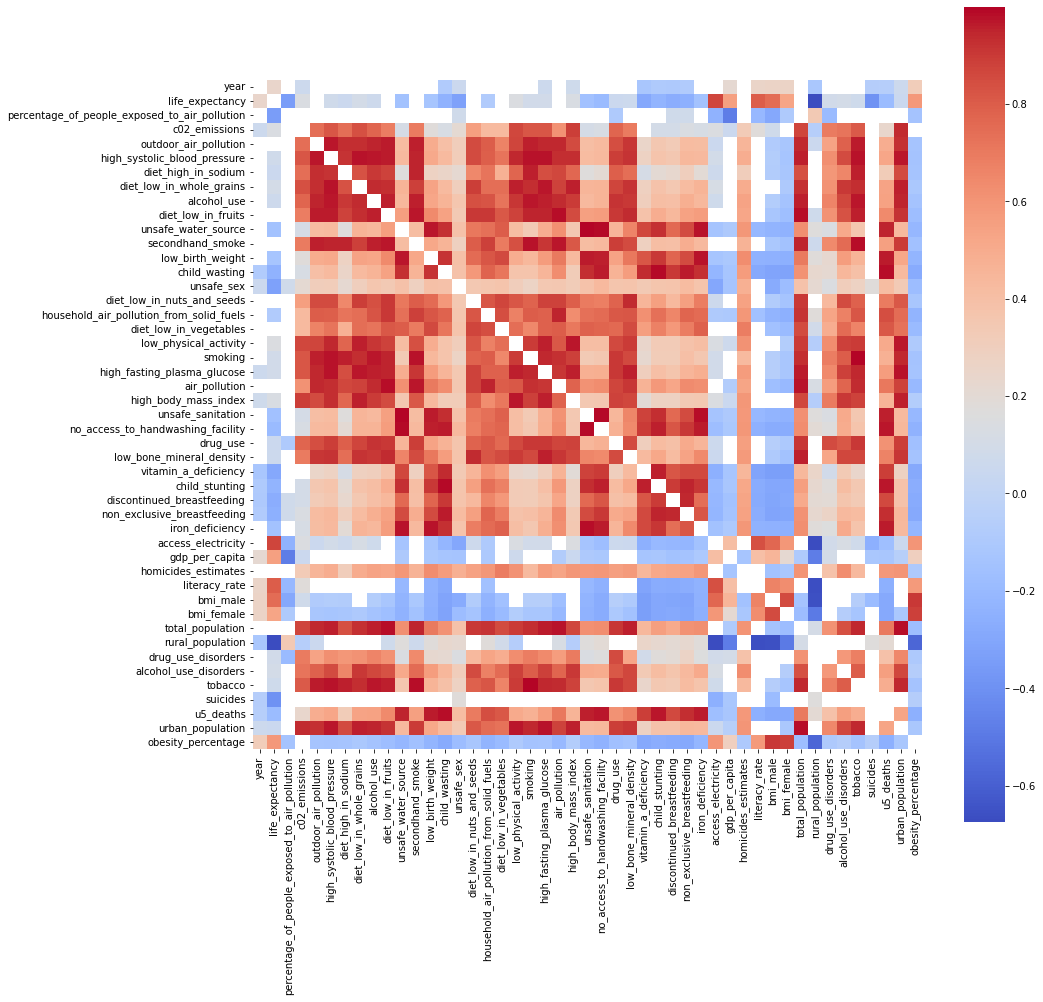

In [20]:
# ---- correlation matrix of the columns (with a statistical significance of 0.1%) and a scatter plot of medv(lstat)
import seaborn as sns
## Import pearsonr function from scipy -- calculate the correlation and p-value between two columns
from scipy.stats import pearsonr

## Calculate the correlations between the columns
df_corrs = df.corr(method='pearson')

## Calculate the p-value, as the second element of the response from the pearsonr function. 
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1])

## Establish the mask, to hide values without a given statistical significance
ptg_stat_sig = 0.1/100
mask = pval > ptg_stat_sig

## Plot the correlation matrix using seaborn's heatmap function
print("The result heatmap is:")
plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(df_corrs, mask = mask, square = True, cmap = 'coolwarm', annot = False)

In [21]:
df = df.drop(['percentage_of_people_exposed_to_air_pollution','suicides'],axis=1)

intrcpt :: 37.454414787
   year :: 0.000000027
c02_emissions :: -0.000000253
outdoor_air_pollution :: -0.000010194
high_systolic_blood_pressure :: 0.000009449
diet_high_in_sodium :: -0.000031301
diet_low_in_whole_grains :: 0.000001748
alcohol_use :: -0.000011643
diet_low_in_fruits :: 0.000016512
unsafe_water_source :: 0.000002490
secondhand_smoke :: 0.000075050
low_birth_weight :: 0.000022425
child_wasting :: -0.000025747
unsafe_sex :: 0.000025120
diet_low_in_nuts_and_seeds :: 0.000004739
household_air_pollution_from_solid_fuels :: -0.000012844
diet_low_in_vegetables :: 0.000024764
low_physical_activity :: 0.000079317
smoking :: -0.000022942
high_fasting_plasma_glucose :: -0.000020916
air_pollution :: -0.000014080
high_body_mass_index :: 0.000004377
unsafe_sanitation :: -0.000003979
no_access_to_handwashing_facility :: -0.000012054
drug_use :: -0.000053211
low_bone_mineral_density :: -0.000030962
vitamin_a_deficiency :: -0.000003011
child_stunting :: -0.000009030
discontinued_breastfee

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = medv_pred


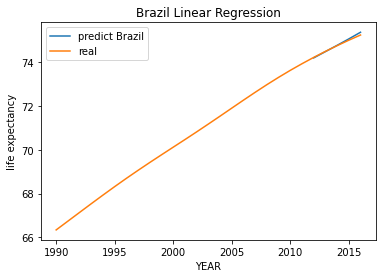

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

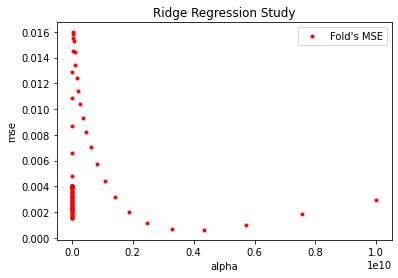

best mse: 0.0006193821530958132 best alfa: 4328761281.083061 

intrcpt :: 30.964029547
   year :: 0.000000000
life_expectancy :: 0.000001266
c02_emissions :: 0.000000043
outdoor_air_pollution :: 0.000000174
high_systolic_blood_pressure :: 0.000000016
diet_high_in_sodium :: 0.000000040
diet_low_in_whole_grains :: 0.000000009
alcohol_use :: 0.000000008
diet_low_in_fruits :: 0.000000011
unsafe_water_source :: 0.000000080
secondhand_smoke :: -0.000000091
low_birth_weight :: -0.000000025
child_wasting :: 0.000000078
unsafe_sex :: 0.000000005
diet_low_in_nuts_and_seeds :: -0.000000063
household_air_pollution_from_solid_fuels :: 0.000000035
diet_low_in_vegetables :: 0.000000043
low_physical_activity :: 0.000000035
smoking :: 0.000000074
high_fasting_plasma_glucose :: -0.000000022
air_pollution :: 0.000000266
high_body_mass_index :: 0.000000005
unsafe_sanitation :: 0.000000025
no_access_to_handwashing_facility :: 0.000000054
drug_use :: 0.000000042
low_bone_mineral_density :: 0.000000001
vitam

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


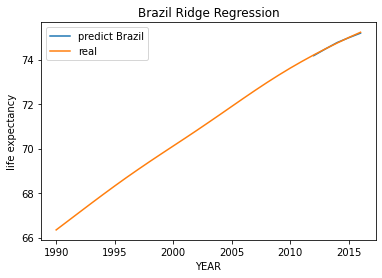

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

best mse: 0.00037521323792193714 best alfa: 14.174741629268048 



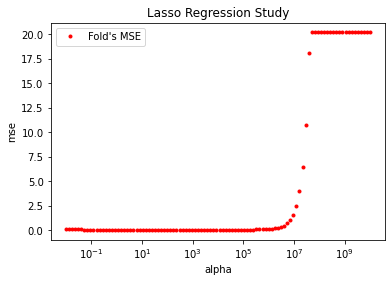

intrcpt :: 70.255954545
   year :: 0.000000000
life_expectancy :: -0.000000000
c02_emissions :: 0.000000000
outdoor_air_pollution :: 0.000000000
high_systolic_blood_pressure :: 0.000000000
diet_high_in_sodium :: 0.000000000
diet_low_in_whole_grains :: -0.000000000
alcohol_use :: 0.000000000
diet_low_in_fruits :: -0.000000000
unsafe_water_source :: 0.000000000
secondhand_smoke :: -0.000000000
low_birth_weight :: -0.000000000
child_wasting :: 0.000000000
unsafe_sex :: -0.000000000
diet_low_in_nuts_and_seeds :: -0.000000000
household_air_pollution_from_solid_fuels :: 0.000000000
diet_low_in_vegetables :: 0.000000000
low_physical_activity :: 0.000000000
smoking :: -0.000000000
high_fasting_plasma_glucose :: -0.000000000
air_pollution :: 0.000002343
high_body_mass_index :: -0.000000000
unsafe_sanitation :: -0.000000000
no_access_to_handwashing_facility :: 0.000000000
drug_use :: 0.000000000
low_bone_mineral_density :: -0.000000000
vitamin_a_deficiency :: -0.000000000
child_stunting :: 0.000

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


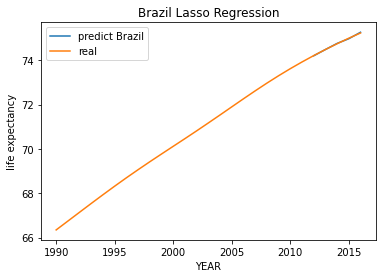

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

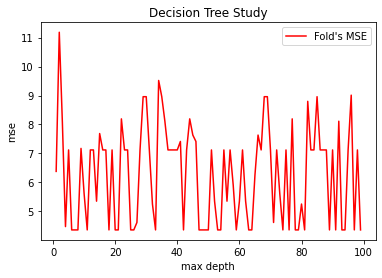

best tree: max_depth = 6
R2: -32.40389498346593


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


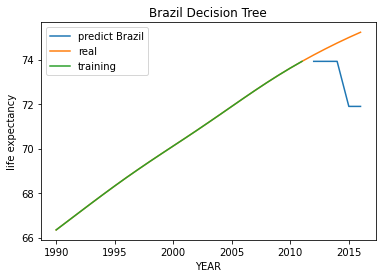

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

best tree: max_features = 21
mse:  1.424560430259931


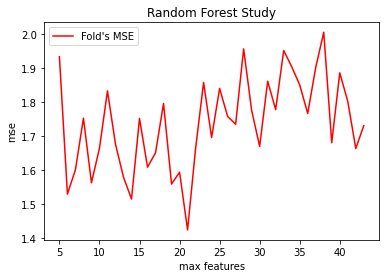

R2:


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


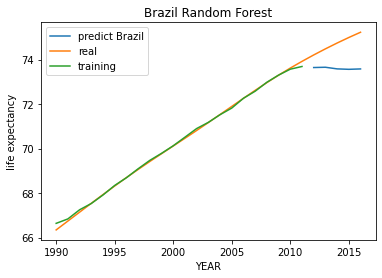

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:545: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

best GB: learning rate = 1.6


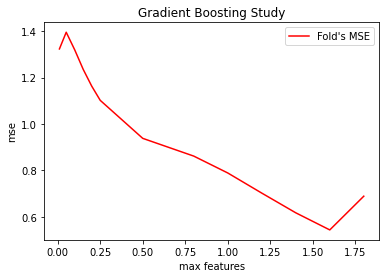

R2: -3.161071673347677


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:615: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


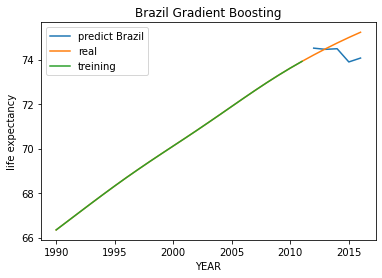

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

intrcpt :: -28.664760071
   year :: 0.000003810
c02_emissions :: -0.000002526
outdoor_air_pollution :: 0.000185650
high_systolic_blood_pressure :: -0.000522573
diet_high_in_sodium :: -0.000871466
diet_low_in_whole_grains :: -0.001454983
alcohol_use :: -0.000301227
diet_low_in_fruits :: -0.000932794
unsafe_water_source :: -0.000310359
secondhand_smoke :: 0.000273158
low_birth_weight :: -0.000208669
child_wasting :: 0.000835475
unsafe_sex :: -0.000036348
diet_low_in_nuts_and_seeds :: -0.000987939
household_air_pollution_from_solid_fuels :: -0.000193546
diet_low_in_vegetables :: -0.000589638
low_physical_activity :: 0.000860041
smoking :: 0.000142632
high_fasting_plasma_glucose :: 0.000770940
air_pollution :: -0.000096943
high_body_mass_index :: -0.000033826
unsafe_sanitation :: 0.000016618
no_access_to_handwashing_facility :: 0.001385782
drug_use :: -0.000061475
low_bone_mineral_density :: -0.000343670
vitamin_a_deficiency :: 0.000548128
child_stunting :: -0.000008320
discontinued_breast

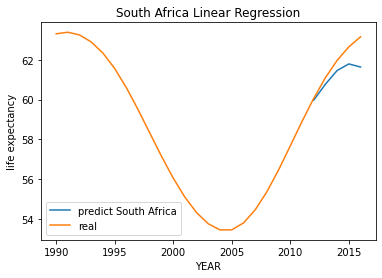

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

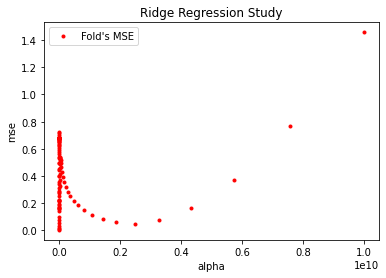

best mse: 0.0041033965139298315 best alfa: 932.60334688322 

intrcpt :: -19.526493760
   year :: 0.000001821
life_expectancy :: -0.000002683
c02_emissions :: -0.000050800
outdoor_air_pollution :: -0.000555472
high_systolic_blood_pressure :: -0.000475766
diet_high_in_sodium :: -0.000719513
diet_low_in_whole_grains :: -0.000159147
alcohol_use :: -0.000394442
diet_low_in_fruits :: -0.000168844
unsafe_water_source :: 0.000243926
secondhand_smoke :: -0.000412350
low_birth_weight :: 0.001028977
child_wasting :: -0.000030433
unsafe_sex :: -0.000480582
diet_low_in_nuts_and_seeds :: -0.000262533
household_air_pollution_from_solid_fuels :: -0.000315738
diet_low_in_vegetables :: 0.000426842
low_physical_activity :: 0.000040432
smoking :: 0.000578232
high_fasting_plasma_glucose :: 0.000096151
air_pollution :: 0.000088661
high_body_mass_index :: -0.000051262
unsafe_sanitation :: 0.000655832
no_access_to_handwashing_facility :: -0.000012075
drug_use :: -0.000158049
low_bone_mineral_density :: 0.0001

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


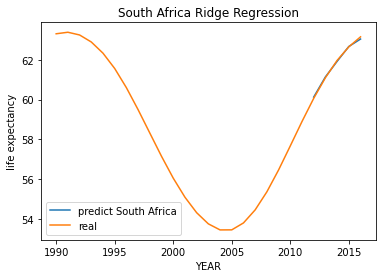

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e-01, tolerance: 2.758e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.820e-01, tolerance: 2.758e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

best mse: 0.04724106050019972 best alfa: 3764.9358067924713 



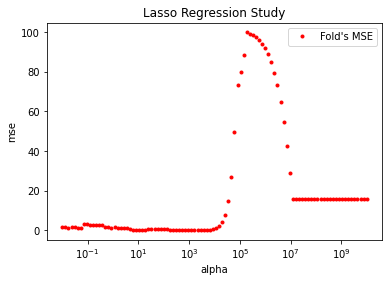

intrcpt :: 57.953863636
   year :: -0.000000000
life_expectancy :: 0.000000000
c02_emissions :: -0.000000000
outdoor_air_pollution :: -0.000000000
high_systolic_blood_pressure :: -0.000000000
diet_high_in_sodium :: -0.000000000
diet_low_in_whole_grains :: -0.000000000
alcohol_use :: -0.000000000
diet_low_in_fruits :: -0.000000000
unsafe_water_source :: -0.000000000
secondhand_smoke :: -0.000000000
low_birth_weight :: 0.000000000
child_wasting :: -0.000042691
unsafe_sex :: -0.000000000
diet_low_in_nuts_and_seeds :: -0.000000000
household_air_pollution_from_solid_fuels :: -0.000000000
diet_low_in_vegetables :: -0.000000000
low_physical_activity :: -0.000000000
smoking :: -0.000000000
high_fasting_plasma_glucose :: -0.000000000
air_pollution :: -0.000000000
high_body_mass_index :: -0.000000000
unsafe_sanitation :: -0.000000000
no_access_to_handwashing_facility :: -0.000000000
drug_use :: -0.000000000
low_bone_mineral_density :: 0.000000000
vitamin_a_deficiency :: 0.000000000
child_stuntin

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


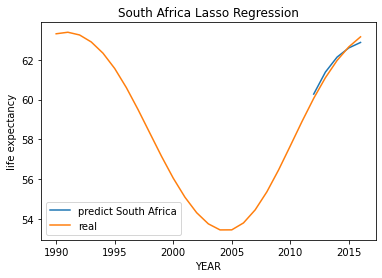

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

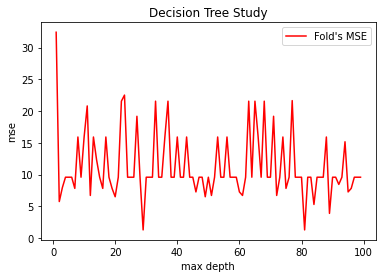

best tree: max_depth = 29
R2: -0.04143828546542094


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


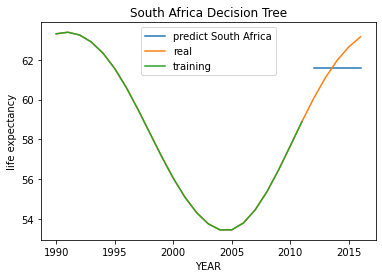

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Giovanna\anaconda3\envs\advaut\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

best tree: max_features = 20
mse:  11.25090309291977


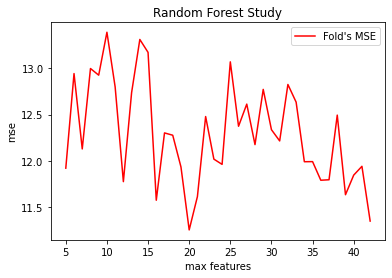

R2:


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


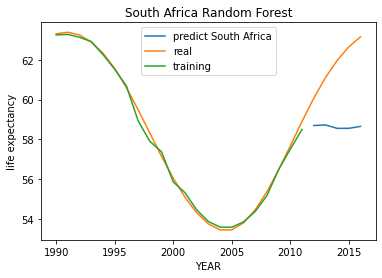

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:545: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

best GB: learning rate = 0.05


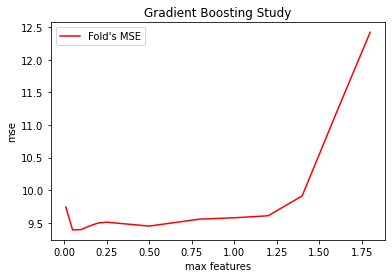

R2: -6.699838578131546


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:615: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predict'] = y_pred_best


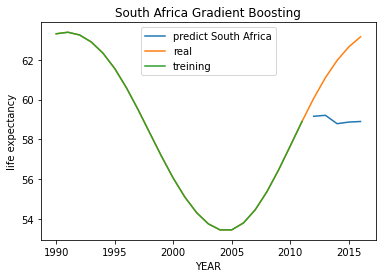

C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.drop(df_results.columns.difference(c_not_delete),inplace=True,axis=1)
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['MSE']=best_mse
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_14908/3426183550.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [22]:
def choose_countries(df,list_country):
    
    data = df[df['country_name']==list_country[0]]
    i=0 
    for country in list_country:
        if i>0:
            df1 = df[df['country_name']==country] #australia #Brazil
            data = pd.concat([data,df1])
        i+=1
    return data
        



def pipeline(df,list_country,year):
    df1=choose_countries(df,list_country )
    

    df1 = df[df['country_name']==list_country[0]] #australia #Brazil
    #df1 = df.loc[idx]
    df1=df1.dropna(axis=1)

    df1 = pd.get_dummies(df1, columns=['country_name'])
     
    

    #excluded = [x for x in df.columns if x not in df1.columns]
    #print(excluded)
    
#     neural_network(df1,list_country,year)
    

    df2=reg_lin(df1,list_country,year)  
    df3=ridge(df1,list_country,year)
    df4=lasso(df1,list_country,year)
    df5=decision_tree(df1,list_country,year)
    df6=random_forest(df1,list_country,year)
 
    
    df7=gradient_boosting(df1,list_country,year)

    df_resultados = pd.concat([df2,df3,df4,df5,df6,df7])
    
    df_resultados.columns = df_resultados.columns.str.lstrip('country_name_')
    
    
    df_resultados['Location'] = df_resultados[list_country].idxmax(1)

    df_resultados.drop(list_country,axis=1,inplace=True)
    df_resultados = df_resultados.rename(columns={'':'year'})  
    
 
    return df_resultados

list_country = [['Brazil'],['South Africa']]#,['United States'],['Portugal'],['South Africa'],['Switzerland']]
year = 2011

df_resultados = []

i=0
for country in list_country:
    
    if i ==0:
        df_resultados = pipeline(df,country,year)
    else:
        df_apoio = pipeline(df,country,year)
 
        df_resultados = pd.concat([df_resultados,df_apoio])
    
    i+=1
df_apoio
create_table(df=df_resultados,tablename='results',conn=conn )